In [1]:
term = 25
target = "unsold_margin"
target = "purchase_margin"

target_col = "diff_unsold_margin_volume_ratio"
target_col = "diff_purchase_margin_volume_ratio"
desc = False

In [2]:
# 読み込みファイルパスの設定とimportしたいmoduleパス(pythonパス)の設定
from pathlib import Path
import os, sys

CURRENT_DIR = Path(os.getcwd())
PJ_DIR = CURRENT_DIR.parent.parent
LIB_DIR = PJ_DIR / "lib"
DATA_DIR = PJ_DIR / "data" 

sys.path.append(str(LIB_DIR))

# notebook内で利用するmoduleのimport
from lib_dataprocess import CreditbalancePl, PricelistPl, read_data, PricelistFig
import polars as pl
from datetime import date
from dateutil.relativedelta import relativedelta

In [3]:
###### 空売り踏み上げの痕跡を探す

In [4]:
# 信用残高データの加工
CPL = CreditbalancePl()
CPL.with_columns_margin_volume_ratio()
CPL.with_columns_diff_margin()
CPL.with_columns_diff_margin_rate()
drop_cols = ["diff_purchase_margin", "purchase_margin_volume_ratio", "diff_purchase_margin_rate"]
selected_cols = [c for c in CPL.df.columns if c not in drop_cols]
df = CPL.df.select(selected_cols)
# diff_unsold_marginが日足平均出来高に対してどの程度の増減であったか。
df = df.with_columns([
    (pl.col("diff_unsold_margin") / pl.col("volume_ma25")).round(2).alias("diff_vol_ratio")
])
c_df =df

In [5]:
# 日足データの加工
fp = DATA_DIR/"reviced_pricelist.parquet"
df = read_data(fp)
RPL = PricelistPl(df)

In [6]:
RPL.convert_daily_to_weekly()

In [7]:
df = RPL.df
# 週の始値~終値までの騰落率列を追加
df = df.with_columns([
    (pl.lit(100)*(pl.col("close") - pl.col("open"))/pl.col("open")).round(1).alias("updown_r")
])
rpl_df = df

In [8]:
##### 連結してみる

In [9]:
rpl_df = rpl_df.select([
    "code", 
    "date",
    "updown_r"
])
df = c_df.join(rpl_df, on=["code", "date"], how="left")
c_rpl_df = df

In [43]:
c_rpl_df\
.filter(pl.col("volume_ma25")>100000)\
.filter(pl.col("diff_vol_ratio")<-1)\
.sort(by=["updown_r"], descending=[True])[10:15]

code,date,unsold_margin,purchase_margin,volume_ma25,unsold_margin_volume_ratio,diff_unsold_margin,diff_unsold_margin_rate,diff_vol_ratio,updown_r
i64,date,i64,i64,f64,f64,i64,f64,f64,f64
8508,2019-02-22,660800,4316800,447768.0,1.48,-723800,-52.3,-1.62,17.5
7245,2009-03-27,715000,158000,112800.0,6.34,-137000,-16.1,-1.21,17.3
9072,2024-06-21,389700,45900,497552.0,0.78,-926300,-70.4,-1.86,16.6
7971,2011-03-18,60000,102000,109880.0,0.55,-114000,-65.5,-1.04,16.2
8011,2023-03-03,256400,187100,146716.0,1.75,-253100,-49.7,-1.73,15.5


In [11]:
##### chart

In [48]:
code = 9072
dt = date(2024, 6, 21)
weeks = 4

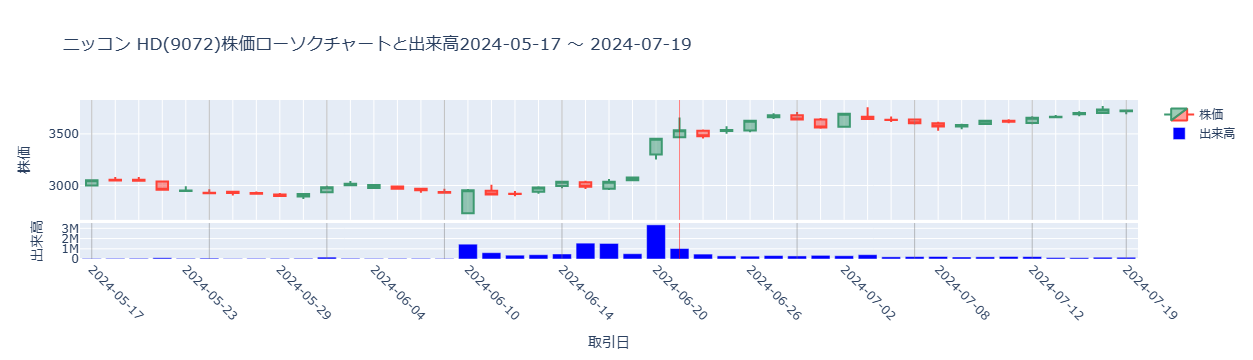

In [49]:
# 日足チャート
start_date = dt - relativedelta(days = 7 * (weeks + 1))
end_date = dt + relativedelta(days = 7 * weeks)
PFIG = PricelistFig(code, start_date=start_date, end_date=end_date)

# 週末にvline
df = read_data(fp)
RPL = PricelistPl(df)
df = RPL.df
df = df.filter(pl.col("code")==code)\
.filter(pl.col("date")>=start_date)\
.filter(pl.col("date")<=end_date)
RPL = PricelistPl(df)
RPL.with_columns_weekid()
pdf = RPL.df
pdf = pdf.group_by(["weekid"]).agg([
    pl.col("date").last()
]).sort(by=["weekid"])
vline_dates = pdf["date"].to_list()
vline_dates.remove(dt)
for d in vline_dates:
    PFIG.add_vline(d)
PFIG.add_vline(dt, color="red")

PFIG.fig.show()
